In [39]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
from scipy.spatial import Delaunay
roi = '$\\ell_pER$'

In [40]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots", "results")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
main_df["orientation"] = main_df["orientation"].fillna("fourier", inplace=False)
main_df_all = main_df.copy()
main_df = main_df[main_df["failure_type"] == "pass"]
np.random.seed(0)

In [41]:
main_df = regenerate_hulls(sample_limit= 5000 )
main_df["orientation"] = main_df["orientation"].fillna("fourier", inplace=False)

100%|██████████| 105/105 [00:11<00:00,  8.80it/s]

Main DF (before frequency): (1152, 45)
Main DF (after frequency): (1152, 46)
Main DF (after result categorization): (1152, 49)


In [42]:
def in_hull(p, hull):
    if hasattr(hull, 'vertices') and not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)
    elif not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(p) >= 0

def get_hull_centroid(hull, log =False):
    # Extract ordered convex hull vertices
    polygon = hull.points[hull.vertices]
    if log:
        polygon = np.log10(polygon)

    # Close the polygon if needed
    if not np.allclose(polygon[0], polygon[-1]):
        polygon = np.vstack([polygon, polygon[0]])

    x, y = polygon[:, 0], polygon[:, 1]
    cross = x[:-1] * y[1:] - x[1:] * y[:-1]
    area = 0.5 * np.sum(cross)

    if np.isclose(area, 0):
        return np.mean(polygon, axis=0)  # fallback for degenerate polygon

    cx = np.sum((x[:-1] + x[1:]) * cross) / (6 * area)
    cy = np.sum((y[:-1] + y[1:]) * cross) / (6 * area)

    return np.array([cx, cy])
def in_hull_list(p, hulls):
   return np.any([in_hull(p, hull) for hull in hulls], axis=0)

0.09087556048135428 20.00282856860364 0.004902068337936946 22.22193325014087


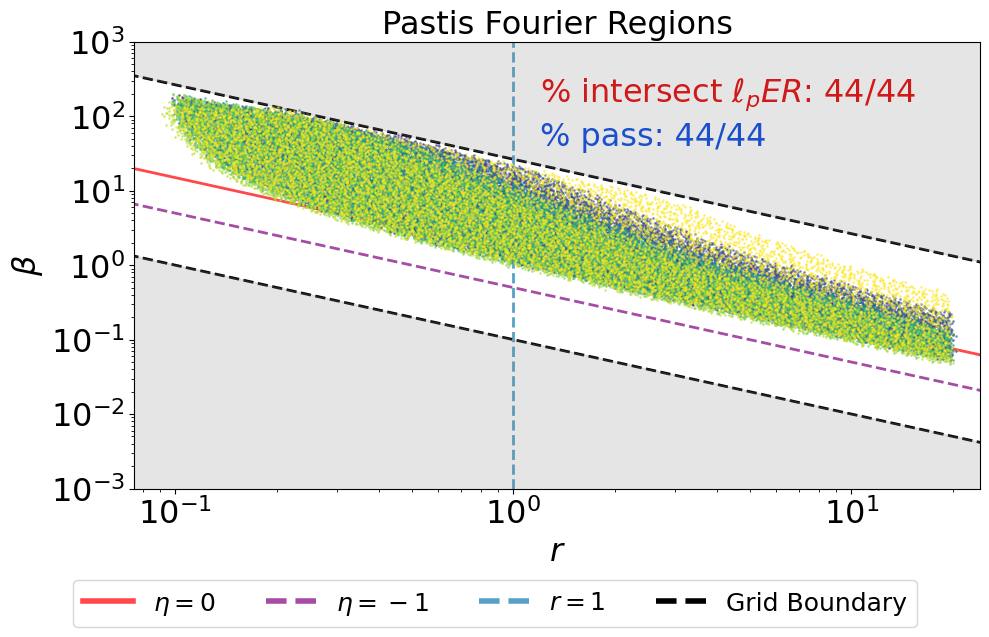

In [ ]:
from sympy import Line2D
from matplotlib.lines import Line2D


num_points = 150
JITTER_FACTOR = 50
size = 1
dataset = ("pastis", "full")
direction = "fourier"
fontsize=23
dataset_fontsize = 40


# Add a fourth column to the right for the new plots
fig, ax = plt.subplots(figsize=(10, 6))
global_xmax = 0
global_ymax = 0
global_xmin = np.inf
global_ymin = np.inf

## SPECIFIC DIRECTION PLOTTING
if direction != "all":
    df = main_df[(main_df["dataset"] == dataset[0]) & (main_df["subset"] == dataset[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == dataset[0]) & (main_df_all["subset"] == dataset[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()
    group_list = df["group"].unique()
    hull_list = []
    all_hulls = []
    for group in group_list:
        hull_list.append(df[df["group"] == group]["hull"])
        all_hulls.extend(df[df["group"] == group]["hull"])
    if len(all_hulls) == 0:
        raise ValueError("No hulls found for the specified criteria.")
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


    if xmax > global_xmax:
        global_xmax = xmax
    if ymax > global_ymax:
        global_ymax = ymax
    if xmin < global_xmin:
        global_xmin = xmin
    if ymin < global_ymin:
        global_ymin = ymin
        
    color_map = plt.get_cmap('viridis')
    num_groups = len(group_list)
    group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)

    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
    ax.set_xlabel("r")
    ax.set_ylabel("beta")
    ax.set_xscale('log')
    ax.set_yscale('log')
    temp_df = df[df["orientation"] == direction]
    #ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")

    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
    ax.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
        textcoords='data', color='xkcd:red', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    ax.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    

### ALL DIRECTIONS PLOTTING
else:
    ax4 = ax
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned")].copy()
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        raise ValueError("No hulls found for the specified criteria.")
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
        textcoords='data', color='xkcd:red', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    ax4.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend(markerscale=10, fontsize=fontsize-6)


### GLOBAL BOUNDARIES AND ROI PLOTTING
x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
eta_vals_global = 0 * np.zeros_like(x_vals_global)
eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
eta_neg_1 = -1 + np.zeros_like(x_vals_global)

roi_global = (eta_vals_global + 1.5) / x_vals_global
roi_lower = (eta_roi_lower + 1.5) / x_vals_global
roi_upper = (eta_roi_upper + 1.5) / x_vals_global
beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global

ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
#ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.7)
ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.7)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)


ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
#ax.set_ylim(ylim)
ax.set_ylim([1e-3, 1e3])




### LABELS AND LEGENDS
plt.title("Pastis Fourier Regions", fontsize = fontsize)
ax.set_ylabel(r"$\beta$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
        

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$", alpha=0.7),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$', alpha=0.7),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

#fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize-5, bbox_to_anchor=(0.5, -0.075), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])


print(global_xmin, global_xmax, global_ymin, global_ymax)
if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_pastis_fourier.png"), bbox_inches='tight', dpi=DPI)

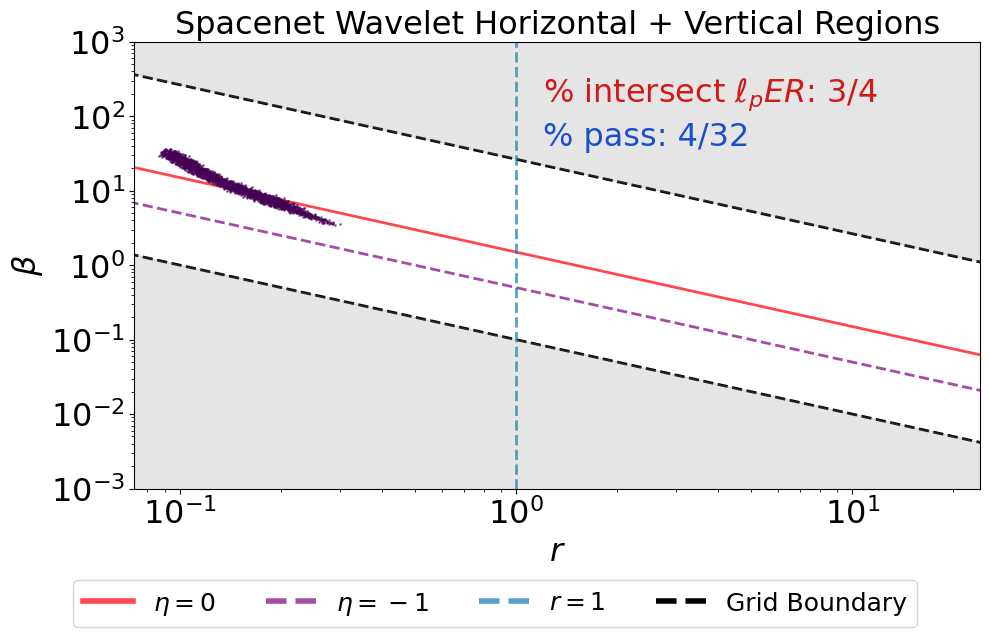

In [ ]:
from sympy import Line2D
from matplotlib.lines import Line2D


num_points = 150
JITTER_FACTOR = 50
size = 1
dataset = ("spaceNet", "full")
direction = "horizVert"
fontsize=23
dataset_fontsize = 40


# Add a fourth column to the right for the new plots
fig, ax = plt.subplots(figsize=(10, 6))
global_xmax = 20.00282856860364
global_ymax = 22.22193325014087
global_xmin = 0.09087556048135428
global_ymin = 0.004902068337936946

## SPECIFIC DIRECTION PLOTTING
if direction != "all":
    df = main_df[(main_df["dataset"] == dataset[0]) & (main_df["subset"] == dataset[1]) & (main_df["transform"] != "learned") & (main_df["orientation"] == direction)].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == dataset[0]) & (main_df_all["subset"] == dataset[1]) & (main_df_all["transform"] != "learned") & (main_df_all["orientation"] == direction)].copy()
    group_list = df["group"].unique()
    hull_list = []
    all_hulls = []
    for group in group_list:
        hull_list.append(df[df["group"] == group]["hull"])
        all_hulls.extend(df[df["group"] == group]["hull"])
    if len(all_hulls) == 0:
        raise ValueError("No hulls found for the specified criteria.")
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()


    if xmax > global_xmax:
        global_xmax = xmax
    if ymax > global_ymax:
        global_ymax = ymax
    if xmin < global_xmin:
        global_xmin = xmin
    if ymin < global_ymin:
        global_ymin = ymin
        
    color_map = plt.get_cmap('viridis')
    num_groups = len(group_list)
    group_colors = {group: color_map(idx / max(num_groups - 1, 1)) for idx, group in enumerate(group_list)}

    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)

    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax.scatter(points[:, 0], 1/points[:, 1], s=size, label=group_list[k], alpha=0.5, color=group_colors[group_list[k]])
    ax.set_xlabel("r")
    ax.set_ylabel("beta")
    ax.set_xscale('log')
    ax.set_yscale('log')
    temp_df = df[df["orientation"] == direction]
    #ax.set_title(f"{DATASET[0]}-{direction} \n {int(sum(temp_df['intersect_roi']))}/{len(temp_df)} hulls intersect ROI")

    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"
    ax.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
        textcoords='data', color='xkcd:red', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    ax.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    

### ALL DIRECTIONS PLOTTING
else:
    ax4 = ax
    df = main_df[(main_df["dataset"] == DATASET[0]) & (main_df["subset"] == DATASET[1]) & (main_df["transform"] != "learned")].copy()
    df = df.dropna(subset=["hull"])
    df_all = main_df_all[(main_df_all["dataset"] == DATASET[0]) & (main_df_all["subset"] == DATASET[1]) & (main_df_all["transform"] != "learned")].copy()
    if df["dataset_type"].unique()[0] == "remote sensing":
        df["orientation"] = df["orientation"].fillna("fourier")
    orientation_list = df["orientation"].unique()
    hull_list = []
    all_hulls = []
    for orientation in orientation_list:
        hull_list.append(df[df["orientation"] == orientation]["hull"])
        all_hulls.extend(df[df["orientation"] == orientation]["hull"])
    if len(all_hulls) == 0:
        raise ValueError("No hulls found for the specified criteria.")
    all_points = np.vstack([hull.points for hull in all_hulls])
    xmin, xmax = all_points[:, 0].min(), all_points[:, 0].max()
    ymin, ymax = all_points[:, 1].min(), all_points[:, 1].max()

    orientation_colors = {"horizVert": "blue", "diagonal": "green", "fourier": "orange", "vertical": "purple", "horizontal": "red"}
    x_vals = np.logspace(np.log10(xmin), np.log10(xmax), num_points)
    y_vals = np.logspace(np.log10(ymin), np.log10(ymax), num_points)
    
    xx, yy = np.meshgrid(x_vals, y_vals)
    points_grid = np.c_[xx.ravel(), yy.ravel()]
    for k, hull in enumerate(hull_list):
        hull_mask = in_hull_list(points_grid, hull)
        points = points_grid[hull_mask]
        points = points + np.random.normal(scale=points / JITTER_FACTOR, size=points.shape)
        ax4.scatter(points[:, 0], 1/points[:, 1], s=size, label=orientation_list[k], alpha=0.5, color=orientation_colors[orientation_list[k]])
    
    temp_df = df
    pass_percent = f"{len(temp_df)}/{len(df_all)}"
    intersect_percent = f"{int(sum(df['intersect_roi']))}/{len(temp_df)}"

    ax4.annotate(f"% intersect {roi}: {intersect_percent}", xy=(1.2, 160), 
        textcoords='data', color='xkcd:red', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    ax4.annotate(f"% pass: {pass_percent}", xy=(1.2, 40), 
        textcoords='data', color='xkcd:blue', fontsize=fontsize, ha='left', 
        bbox=dict(facecolor='none', edgecolor='none', pad=0.5), zorder=1)
    #ax4.set_title(f"Points in Hulls - {DATASET} \n {int(sum(df['intersect_roi']))}/{len(df)} hulls intersect ROI")
    ax4.legend(markerscale=10, fontsize=fontsize-6)


### GLOBAL BOUNDARIES AND ROI PLOTTING
x_vals_global = np.logspace(np.log10(global_xmin) -1 , np.log10(global_xmax+1) + 1, num_points)
eta_vals_global = 0 * np.zeros_like(x_vals_global)
eta_roi_lower = -0.1 * np.zeros_like(x_vals_global)
eta_roi_upper = 0.1 * np.zeros_like(x_vals_global)
eta_20_vals_global = 25 + np.zeros_like(x_vals_global)
eta_lower_global = -1.4 + np.zeros_like(x_vals_global)
eta_neg_1 = -1 + np.zeros_like(x_vals_global)

roi_global = (eta_vals_global + 1.5) / x_vals_global
roi_lower = (eta_roi_lower + 1.5) / x_vals_global
roi_upper = (eta_roi_upper + 1.5) / x_vals_global
beta_20_global = (eta_20_vals_global + 1.5) / x_vals_global
beta_lower_global = (eta_lower_global + 1.5) / x_vals_global
beta_neg_1_global = (eta_neg_1 + 1.5) / x_vals_global

ax.plot(x_vals_global, roi_global, color='xkcd:light red', linestyle='-', label='ROI', zorder=0, linewidth=2)
#ax.fill_between(x_vals_global, roi_lower, roi_upper, color='xkcd:light red')
ax.plot(x_vals_global, beta_20_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
ax.plot(x_vals_global, beta_lower_global, color='black', linestyle='--', label='ROI', zorder=0, linewidth=2)
ax.plot(x_vals_global, beta_neg_1_global, color='purple', linestyle='--', label='ROI', zorder=0, linewidth=2, alpha=0.7)
ax.axvline(x=1, color='xkcd:nice blue', linestyle='--', label='r=1', zorder=0, linewidth=2, alpha=0.7)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill_between(x_vals_global, ylim[0], beta_lower_global, color='gray', alpha=0.2)
ax.fill_between(x_vals_global, ylim[1], beta_20_global, color='gray', alpha=0.2)


ax.set_xlim(global_xmin/1.2, global_xmax*1.2)
#ax.set_ylim(ylim)
ax.set_ylim([1e-3, 1e3])




### LABELS AND LEGENDS
plt.title("Spacenet Wavelet Horizontal + Vertical Regions", fontsize = fontsize)
ax.set_ylabel(r"$\beta$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
        

lw = 4
legend_elements = [
    Line2D([0], [0], color='xkcd:light red', lw=lw, linestyle='solid', label=r"$\eta = 0$"),
    Line2D([0], [0], color='purple', lw=lw, linestyle='dashed', label=r"$\eta = -1$", alpha=0.7),
    Line2D([0], [0], color='xkcd:nice blue', lw=lw, linestyle='dashed', label=r'$r=1$', alpha=0.7),
    Line2D([0], [0], color='black', lw=lw, linestyle='dashed', label="Grid Boundary")
]

#fig.legend(handles=legend_elements, loc='lower center', fontsize=fontsize-5, bbox_to_anchor=(0.5, -0.075), ncol=len(legend_elements))
plt.tight_layout(rect=[0, 0.02, 1, 1])
if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "region_pointalism_spaceNet_horizVert.png"), bbox_inches='tight', dpi=DPI)
